# TS Forecasting Practice (using Seasonal ARIMA)

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pyramid
data = pd.read_csv("C:\\Users\\chika\\Documents\\Github_Files\\Energy Production TS Forecast - ARIMA - Python\\Data\\Energy_Production.csv",index_col=0)
data.head()

,IPG2211A2N
DATE,
1/1/1985,72.6803
2/1/1985,70.8479
3/1/1985,62.6166
4/1/1985,57.6106
5/1/1985,55.4467


Converting index values, which are currently just strings to date format. Also renaming the "IPG2211A2N" column to say 'Energy Production'.

In [7]:
data.index=pd.to_datetime(data.index)
data.columns=['Energy Production']
data.describe()
data.head()

,Energy Production
DATE,
1985-01-01,72.6803
1985-02-01,70.8479
1985-03-01,62.6166
1985-04-01,57.6106
1985-05-01,55.4467


# Checking for typical TS pitfalls 

Creating plots to visually inspect data and check for signs of stationarity and seasonality.

In [10]:
import plotly as ply
ply.tools.set_credentials_file(username='xxx', api_key='xxx')
import cufflinks as cf
data.iplot(title="Energy Production from Jan 1985 till Jan 2019")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



Looks like there is some stationarity and seasonality in the data. Let's see what decomposing the time series into its components i.e. trend, noise, seasonality etc will reveal.

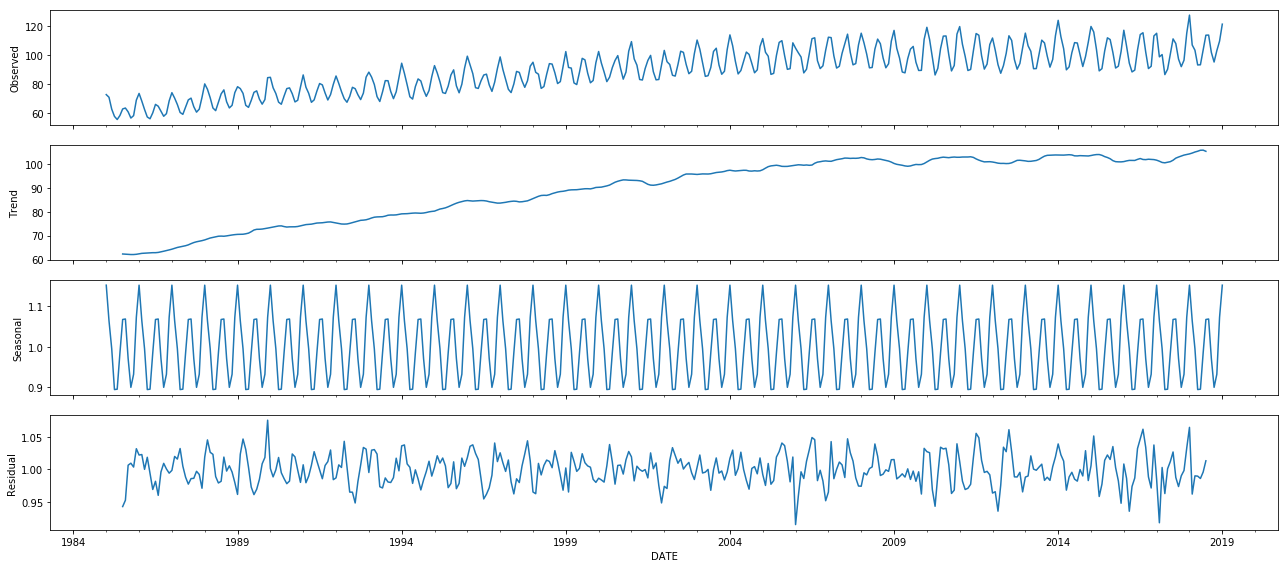

In [19]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='multiplicative',freq=12)
fig = decomposition.plot()
plt.show()

From the graphs above there is definitely a seasonal component in the data and the data appears to be non-stationary. But just to be sure, we will run an Augmented Dickey-Fuller (ADF) test.

In [27]:
from statsmodels.tsa.stattools import adfuller
data1 = data.iloc[:,0].values #converting the data frame to 1 dimension because adfuller() only takes one dimension
dftest = adfuller(data1, autolag='AIC')
#Below is creating a more legible format for the results of the adf test. Running above works but it lacks labels
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -2.402808
p-value                          0.140946
#Lags Used                      15.000000
Number of Observations Used    393.000000
Critical Value (1%)             -3.447099
Critical Value (5%)             -2.868923
Critical Value (10%)            -2.570703
dtype: float64


P-value is much greater than 0.05 suggesting that the data is non-stationary. Next step is to use a seasonal ARIMA for this forecast. This will take into account the seasonality & stationarity in the data. Will search over multiple values of p, d ,q  to pick best values as well as vallues for P, D & Q (the seasonal component of the data).

In [5]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1854.735, BIC=1874.642, Fit time=1.731 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2092.805, BIC=2100.768, Fit time=0.026 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2020.738, BIC=2036.664, Fit time=0.330 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1908.272, BIC=1924.198, Fit time=0.422 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1855.040, BIC=1878.929, Fit time=4.092 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1993.670, BIC=2009.596, Fit time=1.046 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1908.538, BIC=1932.427, Fit time=10.021 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1851.696, BIC=1879.566, Fit time=7.549 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1906.294, BIC=1930.182, Fit time=3.478 seconds
Fit ARIMA: order=(2, 1, 1) 

From the results above, the best model gives us an AIC value of 1836.836. Cool thing about the auto_arima() function is that it will remember the best model so we can use later. Maybe it's not so cool and I'm just easily impressed though :(

# The fun stuff: Training and Testing

I will train on 30 years of the data, 1985 - 2016, and then test on two years of data - 2017, 2018 & 1 month in 2019.

In [44]:
train = data.loc['1985-01-01':'2016-12-01']
test = data.loc['2017-01-01':]
len(test.index)

25

Next step is training the stepwise_model model using the train data and then looking at then checking the accuracy of the model.

In [33]:
results = stepwise_model.fit(train)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0022      0.001     -2.580      0.010      -0.004      -0.001
ar.L1          0.5663      0.045     12.685      0.000       0.479       0.654
ma.L1         -0.9951      0.015    -64.898      0.000      -1.025      -0.965
ar.S.L12       0.4808      0.265      1.812      0.070      -0.039       1.001
ar.S.L24      -0.2435      0.066     -3.716      0.000      -0.372      -0.115
ma.S.L12      -1.1576      0.270     -4.281      0.000      -1.688      -0.628
ma.S.L24       0.4101      0.210      1.953      0.051      -0.002       0.822
sigma2         4.8076      0.330     14.584      0.000       4.161       5.454


The p values suggest that the parameters parameters (AR, MA and S) are significant at the 5% level. Next step is to visually inspect the residuals

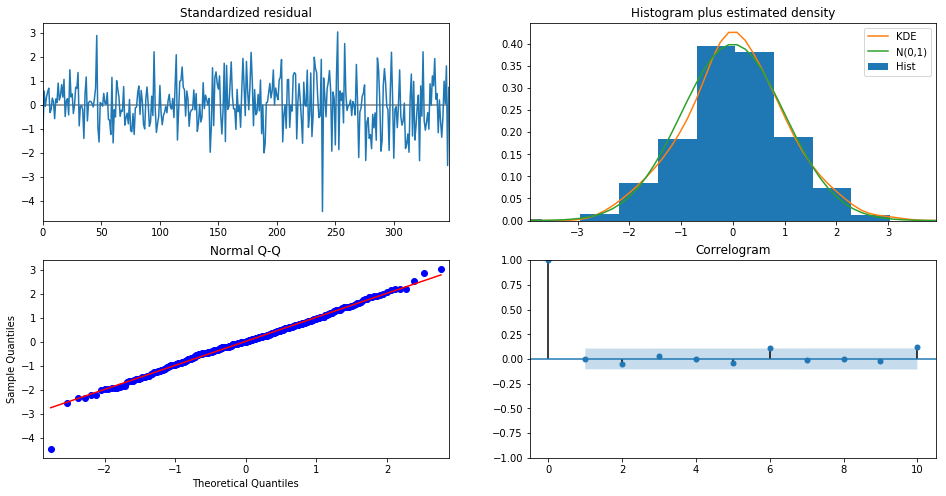

In [34]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

From above the residuals look normally distributed and everything looks about normal. My next step is to then test the model on the test data. Fingers crossed. (25 is the number of periods left to select because it's how many months are left).

In [37]:
forecast = stepwise_model.predict(n_periods=25)
print(forecast)

[109.6603191  100.88235878  89.82916401  92.18287186 102.98811443
 112.12631714 111.22861643 100.03604386  91.71466802  96.22423171
 110.07553043 118.62070716 108.62327582 100.3192954   89.93378939
  92.22457395 102.9189882  112.78818477 111.37869824  99.82480273
  91.62550147  95.96904092 110.40740955 118.99947988 108.84985904]


Now that we have predictions, I will turn them into a data frame (like the original data set) so that it can be overlaid with the original data so we can see how we did

In [89]:
forecast_df = pd.DataFrame(forecast, index=test.index, columns=['Predicted Values']) #converting to data frame
pd.concat([forecast_df, test], axis=1).iplot(title='Predicted vs Actual Values')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



The predicted values track the actual values nicely but not spot on. Let's look at the whole data set so we can get a larger context.

In [92]:
pd.concat([data, forecast_df],axis=1).iplot(title='US Energy Production From 1985 - 2019 w\\ Predicted vs Actual')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



Penultimately, we will look at the RMSE (root mean squared error) of our data to give us a sense of how far our predicted values are from our actual values. We will use a package from the sk.learn library for this.

In [57]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = round(sqrt(mean_squared_error(test, forecast_df)), 2)
print("The Root Mean Squared Is" + " " + str(rmse))

The Root Mean Squared Is 9.29


The RMSE is reported in actual units so is a good representation of how far off you are on average. 9.29 units is pretty good in my opinion.

# Predicting for future years

The final step is to predict and visualise for future time periods. After all, it's not a forecast until you actually forecast. I will do a 10 year forecast because 10 is a nice round number. 

In [86]:
forecast_decade = stepwise_model.predict(n_periods=145, alpha=0.5)
forecast_index_dates = pd.date_range('1/1/2017', periods=145, freq= 'MS') #created to make index dates for forecast data frame - ('MS' ensures the index starts at month start. 'M' would just be month end.
forecast_decade_df = pd.DataFrame(forecast_decade, index=forecast_index_dates, columns=['Predicted Values']) #converting to data frame
pd.concat([data, forecast_decade_df],axis=1).iplot(title='US Energy Production From 1985 - 2019 with 10 Year Forecast')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



And there we have it. An ARIMA TS forecast. 